<a href="https://colab.research.google.com/github/andreunilux/BSP-6/blob/master/BSP6_V2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
#install missing dependancies
!pip install transformers accelerate

#Library used for fine tuning

from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments

# Pandas Dataframe Library
import json
import pandas as pd
import os
from IPython.display import display
import numpy as np 

# HateBert Libarary
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, BertConfig, BertTokenizer


from google.colab import drive
drive.mount('/content/drive')
os.getcwd()
os.chdir('/content/drive/MyDrive/BSP6')   

current_model="bert-base-uncased"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
!pip install autoviz
import pandas as pd
from autoviz import AutoViz_Class

train_data = pd.read_json('train.json', lines=True)
val_data = pd.read_json('val.json', lines=True)
test_data = pd.read_json('test.json', lines=True)

AV = AutoViz_Class()

data = {'col1': [1, 2, 3, 4, 5], 'col2': [5, 4, 3, 2, 1]}
df = pd.DataFrame(train_data)

dft = AV.AutoViz(
    "",
    sep=",",
    depVar="",
    dfte=df,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="server",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=None
)




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Shape of your Data Set loaded: (3325, 4)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
Data cleaning improvement suggestions. Complete them before proceeding to ML modeling.


,Nullpercent,NuniquePercent,dtype,Nuniques,Nulls,Least num. of categories,Data cleaning improvement suggestions
idx,0.000000,100.000000,int64,3325,0,0,possible ID column: drop
label,0.000000,0.090226,int64,3,0,0,
context,0.000000,87.819549,object,2920,0,1,combine rare categories
target,0.000000,99.939850,object,3323,0,1,combine rare categories


    4 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['idx']
No scatter plots with depVar when no depVar is given.
distplots can be found in URL below:
Launching server at http://localhost:36335
violinplots can be found in URL below:
Launching server at http://localhost:41541
Time to run AutoViz (in seconds) = 0


In [55]:
from IPython.core.interactiveshell import dis
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(current_model, do_lower_case=True)

def display_dataset(dataset):
  print("Look at example representative entries of the dataset")
  display(dataset.head(2))
  print("")
  print("Is the dataset complete or are some values missing?")
  display(dataset.count())
  print("")
  print("How balanced is the dataset?")
  display(dataset.label.value_counts())
  print("")

  tokens_c=[]
  length_of_tokens_c=[]
  for sent in dataset.context:
    input_ids = tokenizer.encode(sent,add_special_tokens=True)
    tokens_c.append(input_ids)
    length_of_tokens_c.append(len(input_ids))
  dataset['tokens_c']= tokens_c   
  dataset['length_of_tokens_c']= length_of_tokens_c 
  print("")
  print("token length of the context sentences")
  display(dataset.length_of_tokens_c.describe())
 
  tokens_t=[]
  length_of_tokens_t=[]
  for sent in dataset.target:
    input_ids = tokenizer.encode(sent,add_special_tokens=True)
    tokens_t.append(input_ids)
    length_of_tokens_t.append(len(input_ids))
  dataset['tokens_t']= tokens_t   
  dataset['length_of_tokens_t']= length_of_tokens_t 
  print("")
  print("token length of the target sentences")
  display(dataset.length_of_tokens_t.describe())

  display(dataset.head(4))


Loading BERT tokenizer...


In [56]:
display_dataset(train_data)

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The UK is fucked.,>The ~~UK~~ world is fucked FTFY
1,1,0,Listen to this wisdom.,Where the Fuck did you get that up arrow?



Is the dataset complete or are some values missing?


idx        3325
label      3325
context    3325
target     3325
dtype: int64


How balanced is the dataset?


1    1627
0     922
2     776
Name: label, dtype: int64

Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors



token length of the context sentences


count    3325.000000
mean       58.373233
std        48.147624
min         7.000000
25%        24.000000
50%        43.000000
75%        77.000000
max       640.000000
Name: length_of_tokens_c, dtype: float64


token length of the target sentences


count    3325.000000
mean       16.517594
std         7.609138
min         7.000000
25%        12.000000
50%        16.000000
75%        20.000000
max       191.000000
Name: length_of_tokens_t, dtype: float64

,idx,label,context,target,tokens_c,length_of_tokens_c,tokens_t,length_of_tokens_t
0,0,2,The UK is fucked.,>The ~~UK~~ world is fucked FTFY,"[101, 1996, 2866, 2003, 21746, 1012, 102]",7,"[101, 1028, 1996, 1066, 1066, 2866, 1066, 1066...",14
1,1,0,Listen to this wisdom.,Where the Fuck did you get that up arrow?,"[101, 4952, 2000, 2023, 9866, 1012, 102]",7,"[101, 2073, 1996, 6616, 2106, 2017, 2131, 2008...",12
2,2,1,"""That's different.""",You're right. The ultrasound says it's a girl....,"[101, 1000, 2008, 1005, 1055, 2367, 1012, 1000...",9,"[101, 2017, 1005, 2128, 2157, 1012, 1996, 2731...",23
3,3,2,"Oh fuck offffff, this is just patently untrue ...",Lol you can always spot a valid arguement when...,"[101, 2821, 6616, 2125, 4246, 4246, 1010, 2023...",40,"[101, 8840, 2140, 2017, 2064, 2467, 3962, 1037...",21


In [57]:
display_dataset(val_data)

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,The fact that you think that is sufficient for...,Not being able to find a job for 20 years soun...
1,1,2,Because it's not true you fucking liar. Not ev...,Can't handle the truth hmmmm?



Is the dataset complete or are some values missing?


idx        713
label      713
context    713
target     713
dtype: int64


How balanced is the dataset?


1    356
0    202
2    155
Name: label, dtype: int64



token length of the context sentences


count    713.000000
mean      58.422160
std       44.411254
min        7.000000
25%       25.000000
50%       45.000000
75%       79.000000
max      250.000000
Name: length_of_tokens_c, dtype: float64


token length of the target sentences


count    713.000000
mean      16.468443
std        6.619424
min        7.000000
25%       12.000000
50%       16.000000
75%       20.000000
max       76.000000
Name: length_of_tokens_t, dtype: float64

,idx,label,context,target,tokens_c,length_of_tokens_c,tokens_t,length_of_tokens_t
0,0,2,The fact that you think that is sufficient for...,Not being able to find a job for 20 years soun...,"[101, 1996, 2755, 2008, 2017, 2228, 2008, 2003...",106,"[101, 2025, 2108, 2583, 2000, 2424, 1037, 3105...",18
1,1,2,Because it's not true you fucking liar. Not ev...,Can't handle the truth hmmmm?,"[101, 2138, 2009, 1005, 1055, 2025, 2995, 2017...",17,"[101, 2064, 1005, 1056, 5047, 1996, 3606, 1701...",11
2,2,1,"What about the meme ""lol male tears""?",Male tears is spunk lmfao,"[101, 2054, 2055, 1996, 2033, 4168, 1000, 8840...",14,"[101, 3287, 4000, 2003, 7455, 2243, 1048, 2213...",11
3,3,1,This is not a feminist issue but a capitalist ...,Exactly what part of this is a capitalist issue?,"[101, 2023, 2003, 2025, 1037, 10469, 3277, 202...",120,"[101, 3599, 2054, 2112, 1997, 2023, 2003, 1037...",12


In [58]:
display_dataset(test_data)

Look at example representative entries of the dataset


,idx,label,context,target
0,0,2,Someone on Tumblr actually complied a list and...,Can I get a link to that?
1,1,1,"She has no trouble using Feminism to help her,...",Rand Paul thinks so too. Maybe you should vote...



Is the dataset complete or are some values missing?


idx        713
label      713
context    713
target     713
dtype: int64


How balanced is the dataset?


1    361
0    184
2    168
Name: label, dtype: int64



token length of the context sentences


count    713.000000
mean      59.346424
std       48.508042
min        7.000000
25%       25.000000
50%       43.000000
75%       78.000000
max      256.000000
Name: length_of_tokens_c, dtype: float64


token length of the target sentences


count    713.000000
mean      15.725105
std        5.498228
min        7.000000
25%       12.000000
50%       15.000000
75%       19.000000
max       55.000000
Name: length_of_tokens_t, dtype: float64

,idx,label,context,target,tokens_c,length_of_tokens_c,tokens_t,length_of_tokens_t
0,0,2,Someone on Tumblr actually complied a list and...,Can I get a link to that?,"[101, 2619, 2006, 10722, 14905, 20974, 2941, 2...",42,"[101, 2064, 1045, 2131, 1037, 4957, 2000, 2008...",10
1,1,1,"She has no trouble using Feminism to help her,...",Rand Paul thinks so too. Maybe you should vote...,"[101, 2016, 2038, 2053, 4390, 2478, 20050, 200...",57,"[101, 14566, 2703, 6732, 2061, 2205, 1012, 267...",15
2,2,1,It varies from state to state but generally sp...,Here in Florida we have the Romeo and Juliet ...,"[101, 2009, 9783, 2013, 2110, 2000, 2110, 2021...",136,"[101, 2182, 1999, 3516, 2057, 2031, 1996, 1239...",19
3,3,1,You are literally using it as meme. How can yo...,Seriously OP is a moron for multiple reasons.,"[101, 2017, 2024, 6719, 2478, 2009, 2004, 2033...",28,"[101, 5667, 6728, 2003, 1037, 22822, 2239, 200...",12


In [59]:
from torch.utils.data import TensorDataset
def tokenize(train_data):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  X = []
  for context, target in zip(train_data.context, train_data.target):
    encoded_dict = tokenizer.encode_plus(
                          context, target,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 70,           # Pad & truncate all sentences.
                          padding='max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  
  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  print(input_ids)
  print(len(input_ids))
  attention_masks = torch.cat(attention_masks, dim=0)
  print(attention_masks)
  print(len(attention_masks))
  labels = torch.tensor(train_data.label)

  # Print sentence 0, now as a list of IDs.
  #print('Original: ', train_data.context[0]+train_data.target[0])
  #print('Token IDs:', input_ids[0])  
  #print('Attention_mask:', attention_masks[0])  
  #print('Label:', labels[0])
  dataset = TensorDataset(input_ids, attention_masks, labels)

  return dataset

In [60]:
# Create torch dataset
#need a dictionary
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    
    def __getitem__(self, idx):
      item = self.encodings[idx]
      return item

    def __len__(self):
        return len(self.encodings)



In [61]:
train_dataset = tokenize(train_data)
val_dataset = tokenize(val_data)
test_dataset = tokenize(test_data)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

tensor([[  101,  1996,  2866,  ...,     0,     0,     0],
        [  101,  4952,  2000,  ...,     0,     0,     0],
        [  101,  1000,  2008,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  1005,  ...,  2045,  1012,   102],
        [  101,  1045,  1005,  ...,     0,     0,     0],
        [  101,  2061, 10468,  ...,     0,     0,     0]])
3325
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
3325


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

tensor([[  101,  1996,  2755,  ...,  7750,  1012,   102],
        [  101,  2138,  2009,  ...,     0,     0,     0],
        [  101,  2054,  2055,  ...,     0,     0,     0],
        ...,
        [  101,  2017,  1005,  ...,  8476,  1012,   102],
        [  101,  1045,  2514,  ...,  3226, 30108,   102],
        [  101,  1028,  1045,  ...,  2477,  1012,   102]])
713
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
713


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

tensor([[ 101, 2619, 2006,  ...,    0,    0,    0],
        [ 101, 2016, 2038,  ..., 2032, 1012,  102],
        [ 101, 2009, 9783,  ..., 3423, 1012,  102],
        ...,
        [ 101, 2065, 1037,  ..., 2278, 1012,  102],
        [ 101, 2035, 2112,  ..., 9915, 1012,  102],
        [ 101, 2074, 1037,  ...,    0,    0,    0]])
713
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
713


In [62]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [63]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    current_model, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [64]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [65]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [66]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [67]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [68]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [69]:
import random
import numpy as np
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 5 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:17.
  Batch    80  of    104.    Elapsed: 0:00:34.

  Average training loss: 1.03
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.56
  Validation Loss: 0.97
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:16.
  Batch    80  of    104.    Elapsed: 0:00:32.

  Average training loss: 0.90
  Training epcoh took: 0:00:42

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.92
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:17.
  Batch    80  of    104.    Elapsed: 0:00:33.

  Average training loss: 0.75
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.01
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...

In [70]:


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.033591,0.972231,0.556159,0:00:44,0:00:03
2,0.902747,0.924031,0.599638,0:00:42,0:00:03
3,0.749852,1.006868,0.554952,0:00:43,0:00:03
4,0.614716,1.044789,0.573219,0:00:42,0:00:03
5,0.526977,1.061473,0.573219,0:00:42,0:00:03


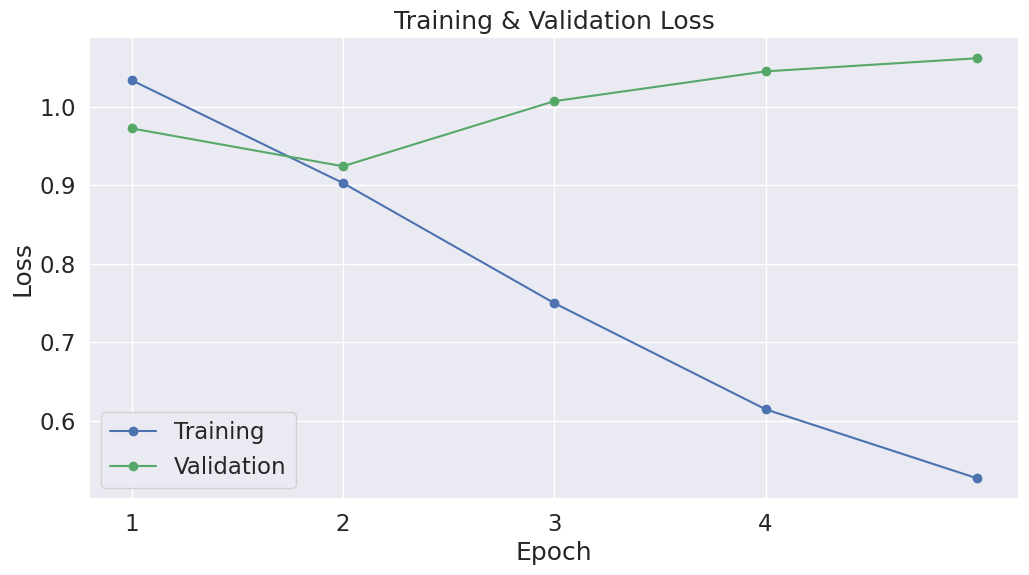

In [71]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()